# Price Anomaly Detection<a id="Top"></a>
<div class="alert alert-block alert-info" style="margin-top: 20px">    
    <font size = 3>
        Table of Content
        <ul>
            <li>1. Data exploring</li>
            <li>2. Data processing</li>     
            <ul>
                <li>2.1 <a href="#Part_2_1">Fixing the wrong <tt>Reion</tt> values for auditor #98s</a></li>  
                <li>2.2 <a href="#Part_2_2">Handling missing <tt>Region</tt> labels</a></li>
                <li>2.3 <a href="#Part_2_3">Handling missing <tt>Banner</tt> labels</a></li>
                <li>2.4 <a href="#Part_2_4">Adjusting the pricing based on regions and banners</a></li>
                <li>2.5 <a href="#Part_2_5">Converting Date into datetime format</a></li>
                <li>2.6 <a href="#Part_2_6">Handling text attributes</a></li>
            </ul>    
            <li>3. <a href="#Part_3">Creating the pivot table</a></li>
            <li>4. <a href="#Part_4">The final cross-table</a></li>
            <li>5. Pricing anomaly</li>
            <ul>
                <li>5.1 <a href="#Part_5_1">Heuristic approach</a></li>
                <li>5.2 <a href="#Part_5_2">Combining PCA and Clustering algorithms</a></li>
                <ul>
                    <li>5.2.1 <a href="#Part_5_2_1">k-means clustering</a></li>
                    <li>5.2.2 <a href="#Part_5_2_2">DBSCAN clustering</a></li>
                </ul>
            </ul>
        </ul>
    </font>
</div>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from matplotlib import cm

cm = plt.cm.get_cmap('tab20c')

def set_figuresize(height=6.0):
    '''
    Set figure size. Use the Golden ratio to compute width and height.
    '''
    width = height*0.5*(1.0+np.sqrt(5.0))

    plt.rcParams['figure.figsize'] = (width, height)
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['mathtext.rm'] = 'serif'

## Data exploring
Load .csv and .json files into pandas dataframes

In [2]:
df_prices   = pd.read_csv('./prices.csv')
df_auditors = pd.read_csv('./auditors.csv')
df_stores   = pd.read_json('./stores.json')

Print out dataframe columns, so that we may setup relationships between ddataframes

In [3]:
print(' df_prices columns:', list(df_prices.columns))
print('df_auditors columns:', list(df_auditors.columns))
print(' df_stores columns:', list(df_stores.columns))

 df_prices columns: ['Auditor ID', 'Date', 'Price', 'Store ID', 'Product ID']
df_auditors columns: ['Auditor ID', 'First', 'Last', 'Region']
 df_stores columns: ['Banner', 'Region', 'Store ID']


We can say that `df_auditors` and `df_stores` are parent dataframes of `df_prices`, as the former two 
datasets contain information required by `df_prices`. Although `df_prices` does not have region information, the
state region can be inferred from `Banner` and `Store ID` columns in `df_stores`.

In [4]:
print('Region in df_auditors:', list(df_auditors['Region'].unique()))
print('  Region in df_stores:', list(df_stores['Region'].unique()))

Region in df_auditors: ['North Carolina', 'New Jersey', 'Tennessee', 'Kentucky']
  Region in df_stores: ['North Carolina', 'New Jersey', 'Kentucky', 'Tennessee', 'Hawaii']


Construct a store list using the dataset that has the most number of unique stores. Follow the same strategy to build the region list.

In [5]:
Product_list    = list(df_prices['Product ID'].unique())
store_list  = list(df_stores['Banner'].unique())
region_list = list(df_stores['Region'].unique())

print('Number of unique products:', len(Product_list))
print('         Number of stores:', len(store_list),'=>', store_list)
print('       Number of regions:', len(region_list),'=>', region_list)

Number of unique products: 1000
         Number of stores: 6 => ['WS1', 'TT', 'SS', 'WS3', 'WS2', 'KM']
       Number of regions: 5 => ['North Carolina', 'New Jersey', 'Kentucky', 'Tennessee', 'Hawaii']


Merge `df_price` and `df_stores` using left merge. This method is like `LEFT JOIN` in SQL. 
After the merge, we display a quick summary of the dataframe.

In [6]:
df = pd.merge(df_prices, df_stores, on='Store ID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12315 entries, 0 to 12314
Data columns (total 7 columns):
Auditor ID    12315 non-null int64
Date          12315 non-null object
Price         12315 non-null float64
Store ID      12315 non-null int64
Product ID    12315 non-null int64
Banner        11511 non-null object
Region        11511 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 769.7+ KB


## 2. Data processing
### 2.1 Fixing the wrong `Reion` values for auditor #98.<a id="Part_2_1"></a>
<a href="#Top">Back to page top</a>

The summary shown above indicates `Banner` and `Region` columns have NaNs. This is becase some store names and 
regions are missing in the original `prices.csv` file. How do we deal with these NaNs? 
The table `df` has an `Auditor ID` column, and we learn from the `df_auditors` table that each auditor is 
associated with a region:

In [7]:
df_auditors.head(100)

,Auditor ID,First,Last,Region
0,234,Sue,Williams,North Carolina
1,536,Bob,Williams,North Carolina
2,98,Jack,Williams,New Jersey
3,203,Jill,Williams,New Jersey
4,304,Jerry,Brown,Tennessee
5,63,Randy,Brown,Tennessee
6,1326,Mike,Brown,Kentucky
7,713,Dave,Brown,Kentucky


Therefore it seems reasonable to fill in the missing `Region` information using the state info extracted from 
the `df_auditors` dataframe. To explore the assumption further, let's do the following evaluations. First create
a temporary dataframe by grabbing `Auditor ID` and `Region` columns from `df`. Then we'll write a list comprehension
that builds every unique `Auditor ID` and `Region` combinations found in `df`.

In [8]:
def check_region(df):
    df_temp = df[['Auditor ID', 'Region']]
    list_tmp = [list(x) for x in set(tuple(x) for x in df_temp.values.tolist())]
    del df_temp    # Delete df_temp because it is no longer needed.
    display(pd.DataFrame(list_tmp, columns=['Auditor ID', 'Region']).sort_values(by='Region').reset_index(drop=True))

In [9]:
check_region(df)

,Auditor ID,Region
0,713,Kentucky
1,1326,Kentucky
2,203,New Jersey
3,98,New Jersey
4,98,North Carolina
5,536,North Carolina
6,234,North Carolina
7,63,Tennessee
8,304,Tennessee
9,203,NaN


So the resulting table is quite interesting. Firstly, it does support the idea that each auditor is
responsible for one and only one region. __However, auditor #98 appears to work in both New York and California. 
This situation is very unusual in reality because it implies making long distance travel that 
potentially costs a lot of time and money. Assuming that the informaion from `df_auditors` is correct, then 
the region information of some of the pricing data collected by auditor #98 is not labeled correctly__. 
The following code snippet fixes the error:

In [10]:
fltr = (df['Auditor ID'] == 98) & (df['Region']=='North Carolina')
for index, row in df[fltr].iterrows():
    df.iat[index, 6] = 'New Jersey'

In [11]:
check_region(df)

,Auditor ID,Region
0,713,Kentucky
1,1326,Kentucky
2,203,New Jersey
3,98,New Jersey
4,536,North Carolina
5,234,North Carolina
6,63,Tennessee
7,304,Tennessee
8,203,NaN
9,536,NaN


Okay so auditor #98's region labels are corrected. The next step is to replace the NaNs in `Region` 
with the correct value.

### 2.2 Handling missing `Region` labels<a id="Part_2_2"></a>
<a href="#Top">Back to page top</a>

Here we are going to replace `Region` NaNs with the label from the auditor's region.

In [12]:
for index, row in df[df.isnull().any(axis=1)].iterrows():
    if row['Auditor ID'] == 203:
        df.iat[index, 6] = 'New Jersey'
    elif row['Auditor ID'] == 536:
        df.iat[index, 6] = 'North Carolina'

Let's run a sanity check:

In [13]:
check_region(df)

,Auditor ID,Region
0,713,Kentucky
1,1326,Kentucky
2,203,New Jersey
3,98,New Jersey
4,536,North Carolina
5,234,North Carolina
6,63,Tennessee
7,304,Tennessee


## 2.3 Handling missing `Banner` labels<a id="Part_2_3"></a>
<a href="#Top">Back to page top</a>

Recall that in the dataframe `df` we have `Store ID` that gives the `Banner`
label. Let's find out the `Store ID` that corresponds to those missing `Banner` labels and check if they are 
in the `Store ID` column in `df_stores`.

In [14]:
list_storeID_missing_region = list(df[df.isnull().any(axis=1)]['Store ID'].unique())
print(list_storeID_missing_region)

[60957, 38472]


In [15]:
for idx in list_storeID_missing_region:
    print("Is store id {0} in df_stores['Store ID']: {1}".format(idx, idx in df_stores['Store ID']))

Is store id 60957 in df_stores['Store ID']: False
Is store id 38472 in df_stores['Store ID']: False


It appears that these ids are not in the `df_stores` database. To handle the NaNs in this column of `df`, we'll
create a separate label `No Store` to mark these data.

In [16]:
for index, row in df[df.isnull().any(axis=1)].iterrows():
    df.iat[index, 5] = 'No Store'

Another round of sanity check on the dataframe `df`:

In [17]:
display(df.isnull().sum())
display(df.info())

Auditor ID    0
Date          0
Price         0
Store ID      0
Product ID    0
Banner        0
Region        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12315 entries, 0 to 12314
Data columns (total 7 columns):
Auditor ID    12315 non-null int64
Date          12315 non-null object
Price         12315 non-null float64
Store ID      12315 non-null int64
Product ID    12315 non-null int64
Banner        12315 non-null object
Region        12315 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 769.7+ KB


None

So upto this point, there is no more missing data.

### 2.4 Adjusting the pricing based on regions and banners<a id="Part_2_4"></a>
<a href="#Top">Back to page top</a>

In this analysis, we'll assume the following model for the adjusted price:

$$ P_{ijk} = P_i\times A_j\times B_k $$

where $P_i$ is the base price for Product ID $i$, $A_j$ is the store multiplier for store $j$, and $B_k$ is the region
multiplier for region $k$. We trivially set all factors to be one. This can always be replaced by a different
one in later analysis. The adjusted price data are grouped under the `Adjusted_Price` column. The original `Price` column will be dropped. So the analysis that follows will be based on `Adjusted_Price`.

Firstly, list the unique region and banner labels:

In [18]:
display(list(df['Region'].unique()))
display(list(df['Banner'].unique()))

['North Carolina', 'New Jersey', 'Kentucky', 'Tennessee']

['WS1', 'TT', 'No Store', 'SS', 'WS3', 'WS2']

So there are six different store banners across 4 states in `df`. But we are going to include Hawaii and Kroger
anyway when we setup price multipliers.

In [19]:
multiplier_store  = {'WS1': 1., 
                     'TT': 1., 
                     'SS': 1., 
                     'WS3': 1., 
                     'WS2': 1., 
                     'KM': 1.,
                     'No Store': 1.}
multiplier_region = {'North Carolina': 1., 
                     'New Jersey': 1., 
                     'Kentucky': 1., 
                     'Tennessee': 1.,
                     'Hawaii': 1.}

Compute the adjusted price, add the results to `df` and drop the original `Price` column from `df`.

In [20]:
adjusted_price = []
for i in range(len(df)):
    if i%1000 == 0:
        print(' Processing df row:{0:6d}'.format(i))
    base_price = df.loc[i]['Price']
    store = df.loc[i]['Banner']
    region = df.loc[i]['Region']
    
    # Compute adjusted price using the simple model provided
    price = base_price * multiplier_region[region] * multiplier_store[store]
    adjusted_price.append(price)

 Processing df row:     0
 Processing df row:  1000
 Processing df row:  2000
 Processing df row:  3000
 Processing df row:  4000
 Processing df row:  5000
 Processing df row:  6000
 Processing df row:  7000
 Processing df row:  8000
 Processing df row:  9000
 Processing df row: 10000
 Processing df row: 11000
 Processing df row: 12000


In [21]:
df = df.assign(Adjusted_Price=adjusted_price)
df = df.drop(['Price'], axis=1)

### 2.5 Converting `Date` into datetime format<a id="Part_2_5"></a>
<a href="#Top">Back to page top</a>

As a side step, we convert the `Date` column into pandas datetime format. This is a one-liner:

In [22]:
df['Date'] = pd.to_datetime(df['Date'])

Out of curiosity, let's take a look at the distribution of dates when the pricing data were taken.

In [23]:
display(list(df['Date'].dt.year.unique()))
display(list(df['Date'].dt.month.unique()))
display(list(np.sort(df['Date'].dt.day.unique())))

[2017]

[10]

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

The data were taken between 10/16/2017 and 10/29/2017.

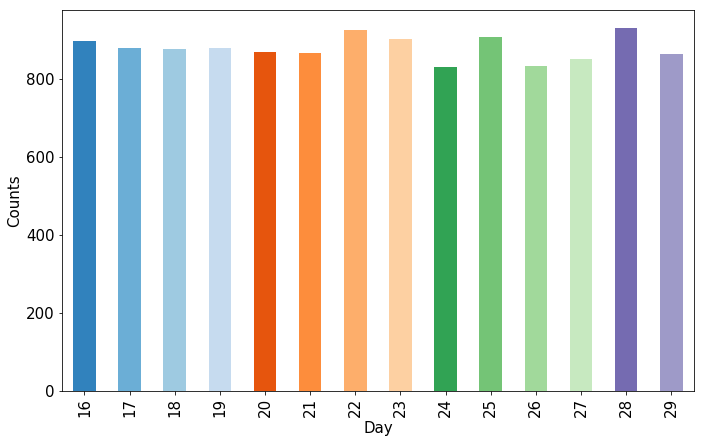

In [24]:
set_figuresize(height=7.0)
df['Date'].groupby(df['Date'].dt.day).count().plot(kind="bar", color=cm.colors)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.show()

In each day, roughtly the same amount of pricing data were collected.

### 2.6 Handling text attributes<a id="Part_2_6"></a>
<a href="#Top">Back to page top</a>

The remaining data processing step will be focusing on dealing with two categorical data: `Banner` and `Region`.
Here we'll just use `Scikit-Learn`'s `LabelEncoder`. 

In [25]:
encoder = LabelEncoder()
df_banner = df['Banner']
df_region = df['Region']

df_banner_encoded = encoder.fit_transform(df_banner)
banner_class = encoder.classes_

df_region_encoded = encoder.fit_transform(df_region)
region_class = encoder.classes_

List the classes constructed by the encoder:

In [26]:
print(banner_class)
print(region_class)

['No Store' 'SS' 'TT' 'WS1' 'WS2' 'WS3']
['Kentucky' 'New Jersey' 'North Carolina' 'Tennessee']


For the `Banner` column, the `No Store` attribute equals category 0, `SS` is 1, `TT` is 2, 
and so on. The same line of logic applies to `Region`. Let's check them out:

In [27]:
display(df_banner.head(3))
display(df_banner.tail(3))
print(df_banner_encoded)

0    WS1
1    WS1
2    WS1
Name: Banner, dtype: object

12312    WS3
12313    WS3
12314    WS3
Name: Banner, dtype: object

[3 3 3 ... 5 5 5]


In [28]:
display(df_region.head(3))
display(df_region.tail(3))
print(df_region_encoded)

0    North Carolina
1    North Carolina
2    North Carolina
Name: Region, dtype: object

12312    Tennessee
12313    Tennessee
12314    Tennessee
Name: Region, dtype: object

[2 2 2 ... 3 3 3]


Now let's create a separate dataframe and replace its the text categorical data with the encoded version.
<a id="df_cat"></a>


In [29]:
df_cat = df.copy()

In [30]:
df_cat['Banner'] = df_banner_encoded
df_cat['Region'] = df_region_encoded

In [31]:
display(df_cat.head(20))
df_cat.info()

,Auditor ID,Date,Store ID,Product ID,Banner,Region,Adjusted_Price
0,234,2017-10-18,66999,268588472,3,2,24.95
1,234,2017-10-27,66999,475245085,3,2,49.71
2,234,2017-10-20,66999,126967843,3,2,25.75
3,234,2017-10-23,66999,708930835,3,2,18.81
4,234,2017-10-23,66999,325885139,3,2,33.32
5,234,2017-10-16,66999,509419735,3,2,40.43
6,234,2017-10-22,66999,736362595,3,2,35.10
7,234,2017-10-21,66999,652377244,3,2,33.65
8,234,2017-10-16,66999,277394644,3,2,22.30
9,234,2017-10-20,66999,996849471,3,2,12.32


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12315 entries, 0 to 12314
Data columns (total 7 columns):
Auditor ID        12315 non-null int64
Date              12315 non-null datetime64[ns]
Store ID          12315 non-null int64
Product ID        12315 non-null int64
Banner            12315 non-null int64
Region            12315 non-null int64
Adjusted_Price    12315 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 769.7 KB


If it is necessary, one can further process or drop the `Date` column of dataframe `df_cat` before feeding 
the dataframe into machine learning algorithms. To create the desired cross-table, we will work with `df` 
instead. Let's proceed.

## 3 Creating the pivot table<a id="Part_3"></a>
<a href="#Top">Back to page top</a>

In order to create the desired pivot table, it is necessary to have unique columns. 
For this reason, we first construct a sub-pivot-table for each given UPC. Then we stick 
all the sub-pivot-tables together. Each sub-pivot-table will have `Banner` as index and `Regions` 
as columns. 

In [32]:
df_final = pd.DataFrame(columns=['Kentucky', 'New Jersey', 'North Carolina', 'Tennessee', 'Product ID'])
count = 0
for i in Product_list:
    count += 1
    
    # Grab the rows from df that correspond to a given UPC and convert the results into a dataframe
    temp = pd.DataFrame(df.loc[df['Product ID'] == i])
    
    # Consruct the sub-pivot-table
    temp = temp.pivot(index='Banner', columns='Region', values='Adjusted_Price').reset_index()
    
    # Add the Product ID label back to the sub-pivot-table
    temp['Product ID'] = [i for j in range(len(temp))]
    
    #if len(temp) != 5:
    #    print(temp)    
    
    # Append the sub-pivot-table to the final one
    df_final = df_final.append(temp, sort=False)
    if count%100 == 0:
        print(' Processed {0:6d} Product IDs'.format(count))   

# Reorder columns
columns=['Product ID', 'Banner', 'Kentucky', 'New Jersey', 'North Carolina', 'Tennessee']  
df_final = df_final[columns].reset_index(drop=True)

 Processed    100 Product IDs
 Processed    200 Product IDs
 Processed    300 Product IDs
 Processed    400 Product IDs
 Processed    500 Product IDs
 Processed    600 Product IDs
 Processed    700 Product IDs
 Processed    800 Product IDs
 Processed    900 Product IDs
 Processed   1000 Product IDs


The following is just a sanity check. Here we compute the total number of price tags processed 
during the construction of pivot tables. Then we compare it agains the total number of rows in the `df` 
dataframe. The two numbers are expected to be identical.

In [33]:
subtotal = 0
for state in ['Kentucky', 'New Jersey', 'North Carolina', 'Tennessee']:
    subtotal += df_final[state].count()
print(' Total number of non-null price tags:',subtotal) 
print(' Total number of non-null rows in df:',len(df))

 Total number of non-null price tags: 12315
 Total number of non-null rows in df: 12315


Display a few rows from `df_final` and a quick summary of the dataframe

In [34]:
display(df_final.head(10))
df_final.info()

,Product ID,Banner,Kentucky,New Jersey,North Carolina,Tennessee
0,268588472,No Store,NaN,24.49,NaN,NaN
1,268588472,SS,23.59,NaN,NaN,23.79
2,268588472,TT,NaN,23.29,NaN,22.59
3,268588472,WS1,NaN,22.13,24.95,NaN
4,268588472,WS2,NaN,23.79,NaN,23.09
5,268588472,WS3,1.99,25.99,29.29,NaN
6,475245085,SS,NaN,55.09,NaN,47.49
7,475245085,TT,NaN,46.49,NaN,45.09
8,475245085,WS1,42.41,44.12,49.71,NaN
9,475245085,WS2,45.59,47.49,NaN,46.09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5594 entries, 0 to 5593
Data columns (total 6 columns):
Product ID        5594 non-null object
Banner            5594 non-null object
Kentucky          3087 non-null float64
New Jersey        3834 non-null float64
North Carolina    1629 non-null float64
Tennessee         3765 non-null float64
dtypes: float64(4), object(2)
memory usage: 262.3+ KB


Apparently, the NaNs tell us that a given UPC is not guaranteed to be available in all states.
There are two simple approaches to deal with the NaNs:
- Ignore the NaNs
- Fill the NaNs with mean or median value of the product.

Here we'll use the second approach. This is done row-by-row using pandas `apply()` function
coupled with a simple `lambda` function that computes the mean value. 

In [35]:
state_columns = ['Kentucky', 'New Jersey', 'North Carolina', 'Tennessee']

df_mean = df_final[state_columns].apply(lambda row: row.fillna(row.mean()), axis=1)
for col in df_mean.columns:
    df_final[col] = df_mean[col]
del df_mean

For a given UPC price, compute its average and standard deviation over different regions. Add these results back
to the dataframe `df_final`. In the case where there is only one price data available, the standard deviation
will be zero, as indicated by the argument `ddof=0` of the pandas function `std()`.

In [36]:
df_final['Average_Price'] = df_final[state_columns].mean(numeric_only=True, axis=1)
df_final['Std'] = df_final[state_columns].std(numeric_only=True, ddof=0, axis=1)

## 4 The final cross-table<a id="Part_4"></a>
<a href="#Top">Back to page top</a>

Display the first few rows and a quick summary of the final dataframe `df_final`. Then we export the results to
a `.csv` file.

In [37]:
display(df_final.head(10))
df_final.info()

,Product ID,Banner,Kentucky,New Jersey,North Carolina,Tennessee,Average_Price,Std
0,268588472,No Store,24.49,24.49,24.49,24.490000,24.490000,0.000000
1,268588472,SS,23.59,23.69,23.69,23.790000,23.690000,0.070711
2,268588472,TT,22.94,23.29,22.94,22.590000,22.940000,0.247487
3,268588472,WS1,23.54,22.13,24.95,23.540000,23.540000,0.997021
4,268588472,WS2,23.44,23.79,23.44,23.090000,23.440000,0.247487
5,268588472,WS3,1.99,25.99,29.29,19.090000,19.090000,10.536366
6,475245085,SS,51.29,55.09,51.29,47.490000,51.290000,2.687006
7,475245085,TT,45.79,46.49,45.79,45.090000,45.790000,0.494975
8,475245085,WS1,42.41,44.12,49.71,45.413333,45.413333,2.699725
9,475245085,WS2,45.59,47.49,46.39,46.090000,46.390000,0.696419


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5594 entries, 0 to 5593
Data columns (total 8 columns):
Product ID        5594 non-null object
Banner            5594 non-null object
Kentucky          5594 non-null float64
New Jersey        5594 non-null float64
North Carolina    5594 non-null float64
Tennessee         5594 non-null float64
Average_Price     5594 non-null float64
Std               5594 non-null float64
dtypes: float64(6), object(2)
memory usage: 349.7+ KB


---

#### Define auxiliary plotting functions

In [38]:
def plot_item_pricing(item):
    set_figuresize()
    fltr = df_final['Product ID'] == item
    table = df_final[fltr]
    Banner = df_final['Banner'][fltr]
    avg, std = df_final['Average_Price'][fltr], df_final['Std'][fltr]
    display(table)

    ticks = np.arange(len(Banner))
    plt.bar(ticks, avg, yerr=std, capsize=4, width=0.5, color='r', alpha=0.5)
    plt.ylabel('Average Price', fontsize=15)
    plt.xticks(ticks, ('No Store', 'SS', 'TT', 'WS1', 'WS2', 'WS3'), fontsize=12)    
    plt.yticks(fontsize=15)
    plt.title('Product ID {0} Average Price over States'.format(item), fontsize=15)
    plt.show()

    
def plot_pricing(df, start, stop):
    set_figuresize(height=9.0)
    df[start:stop].plot(color=cm.colors)
    plt.xlabel('Product ID index', fontsize=15)
    plt.ylabel('Average Price', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.title('Product ID index range: {0}-{1}'.format(start, stop), fontsize=15)
    plt.show()
    
    
def show_colors(colors):
    with plt.rc_context(plt.rcParamsDefault):
        fig = plt.figure(figsize=(16, 1), frameon=False)
        ax = fig.add_subplot(111)
        for x, color in enumerate(colors):
            ax.add_patch(
                matplotlib.patches.Rectangle(
                    (x, 0), 1, 1, facecolor=color
                )
            )
            ax.text(x+0.5, 0.5, str(x), va='center', ha='center', fontsize=20)
        ax.set_xlim((0, len(colors)))
        ax.set_ylim((0, 1))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        plt.show()    

---

## 5 Pricing anomaly
### 5.1 Heuristic approach<a id="Part_5_1"></a>
<a href="#Top">Back to page top</a>

From the results of `df_final`, we happen to notice that WS3 price of Product ID 268588472 is way lower than competitors' pricing. Let's visualize this:

,Product ID,Banner,Kentucky,New Jersey,North Carolina,Tennessee,Average_Price,Std
0,268588472,No Store,24.49,24.49,24.49,24.49,24.49,0.000000
1,268588472,SS,23.59,23.69,23.69,23.79,23.69,0.070711
2,268588472,TT,22.94,23.29,22.94,22.59,22.94,0.247487
3,268588472,WS1,23.54,22.13,24.95,23.54,23.54,0.997021
4,268588472,WS2,23.44,23.79,23.44,23.09,23.44,0.247487
5,268588472,WS3,1.99,25.99,29.29,19.09,19.09,10.536366


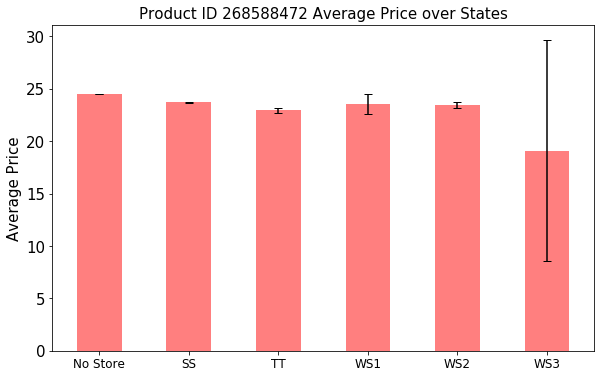

In [39]:
item = 268588472
plot_item_pricing(item)

The figure shows the average price (explained above) of Product ID 268588472 for five banners. First of all, 
we notice that, for this particular item, TT and WS2 have a much smaller price variation across
different regions than competitors. Apparently, the large errorbar of WS3 price indicates an anamoly.
Indeed, if we look at the corresponding table, Product ID 268588472's price in Kentucky is just \\$1.99, which is 
way lower than the \\$23.00 ~ \\$24.00 price tags. Unless there is a supersale going on, otherwise something is
wrong.

Let's do a quick price comparison for the five banners over all of the products. We'll create
another pivot table that lists the prices for each of the store.

In [40]:
df_banner = df_final.pivot_table('Average_Price', index='Product ID', columns='Banner').reset_index()
df_banner = df_banner.drop(['Product ID'], axis=1)
df_banner.head(5)

Banner,No Store,SS,TT,WS1,WS2,WS3
0,5.64,5.64,4.990,5.140000,5.140000,4.390000
1,NaN,54.24,60.190,53.940000,53.256667,39.756667
2,19.49,17.99,17.440,16.560000,17.840000,10.840000
3,8.69,8.49,8.015,7.726667,7.940000,9.340000
4,3.84,3.79,3.390,3.320000,3.490000,1.990000


__Notice here that the NaNs are resulted from the `pivot_table()` action. These NaNs are not some leftovers 
from the table `df_final` before pivoting, they simply mean certain products are not available in `No Store`__.
Now let's plot the price distribution across all products for all banners. For illustration, we'll just 
randomly pick two sets of products, each of which has 50 products.

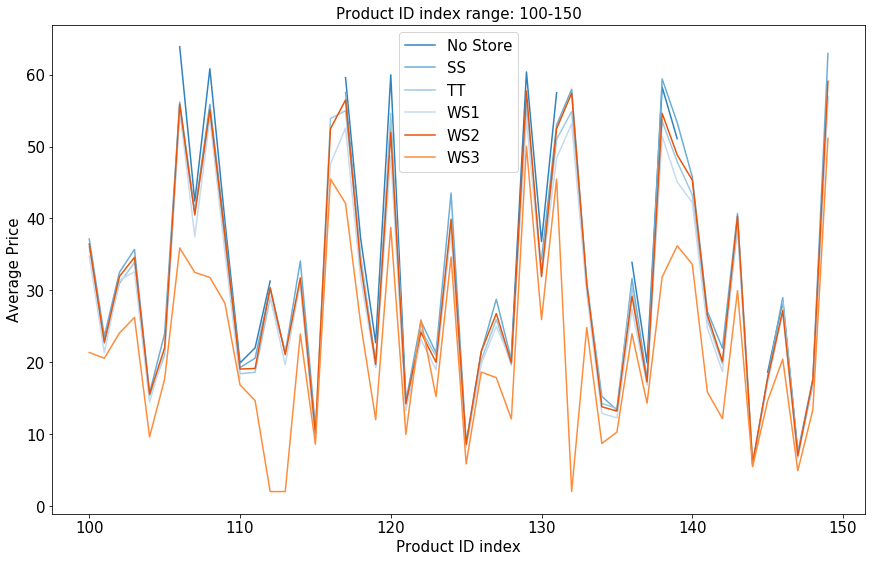

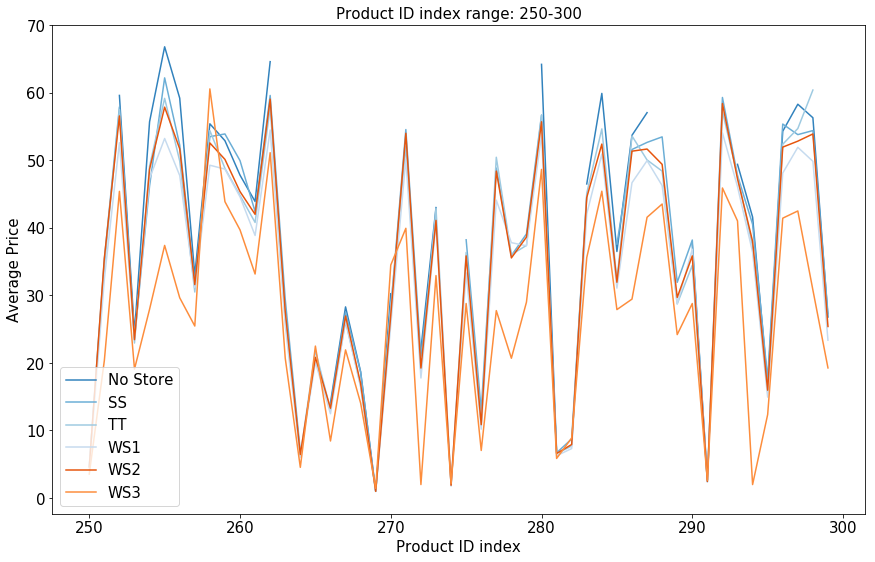

In [41]:
plot_pricing(df_banner, 100, 150)
plot_pricing(df_banner, 250, 300)

The figures tell us that quite a few of WS3 pricing are way below the average. 
Let's dig a bit deeper and look at the WS3 data.

In [42]:
df_WF_anomaly = df_final[ df_final['Banner']=='WS3' ]
df_WF_anomaly.head(20)

,Product ID,Banner,Kentucky,New Jersey,North Carolina,Tennessee,Average_Price,Std
5,268588472,WS3,1.99,25.990000,29.290000,19.090000,19.090000,10.536366
10,475245085,WS3,1.99,51.790000,26.890000,26.890000,26.890000,17.606959
15,126967843,WS3,25.89,25.890000,25.890000,25.890000,25.890000,0.000000
21,708930835,WS3,1.99,19.490000,13.456667,18.890000,13.456667,7.025074
26,325885139,WS3,1.99,34.690000,23.456667,33.690000,23.456667,13.150349
32,509419735,WS3,1.99,41.990000,47.390000,30.456667,30.456667,17.536438
37,736362595,WS3,1.99,36.590000,41.190000,35.490000,28.815000,15.634317
43,652377244,WS3,1.99,34.890000,18.440000,18.440000,18.440000,11.631907
47,277394644,WS3,22.49,22.490000,22.490000,22.490000,22.490000,0.000000
53,996849471,WS3,1.99,12.790000,7.390000,7.390000,7.390000,3.818377


Clearly, the table says there is a problem in WS3 data collected from stores in Kentucky. Let's find out 
the auditors in charge of WS3 in the Kentucky region. We focus on the items listed in the original `df`
that are carried by WS3 in Kentucky. Then, using pandas' `unique()` method on the `Auditor ID` column,
we can filter out the auditor.

In [43]:
fltr = (df['Banner']=='WS3') & (df['Region']=='Kentucky')

# Print the auditor's unique ID number
print('Auditor ID:', df[fltr]['Auditor ID'].unique())
display(df[fltr].head(10))

Auditor ID: [713]


,Auditor ID,Date,Store ID,Product ID,Banner,Region,Adjusted_Price
7637,713,2017-10-24,39287,557031026,WS3,Kentucky,1.99
7638,713,2017-10-29,39287,866698043,WS3,Kentucky,1.99
7639,713,2017-10-27,39287,514730047,WS3,Kentucky,1.99
7640,713,2017-10-29,39287,789986401,WS3,Kentucky,1.99
7641,713,2017-10-23,39287,926444424,WS3,Kentucky,1.99
7642,713,2017-10-23,39287,481217425,WS3,Kentucky,1.99
7643,713,2017-10-27,39287,400625108,WS3,Kentucky,1.99
7644,713,2017-10-19,39287,220433295,WS3,Kentucky,1.99
7645,713,2017-10-19,39287,641206219,WS3,Kentucky,1.99
7646,713,2017-10-25,39287,48258595,WS3,Kentucky,1.99


The results indicate:
1. Only auditor #713 is in charge of collecting WS3's data in the Kentucky region.
2. The pricing data somehow were not recorded properly.

Is the auditor also collecting pricing data from other stores? Let's find out.

In [44]:
fltr = (df['Auditor ID']==713)
print(df[fltr]['Banner'].unique())
print(df[fltr]['Region'].unique())

['WS2' 'WS3']
['Kentucky']


In addition to WS3, let's quickly check auditor #713's data for WS2 and see if there's any anomaly.

In [45]:
fltr = (df['Banner']=='WS2') & (df['Region']=='Kentucky')

# Print the auditor's unique ID number
print('Auditor ID:', df[fltr]['Auditor ID'].unique())
display(df[fltr].head(10))

Auditor ID: [713]


,Auditor ID,Date,Store ID,Product ID,Banner,Region,Adjusted_Price
6429,713,2017-10-25,3948,484719492,WS2,Kentucky,51.99
6430,713,2017-10-17,3948,813117592,WS2,Kentucky,43.59
6431,713,2017-10-24,3948,711957058,WS2,Kentucky,21.39
6432,713,2017-10-21,3948,226080317,WS2,Kentucky,1.99
6433,713,2017-10-24,3948,337353166,WS2,Kentucky,46.79
6434,713,2017-10-21,3948,742726716,WS2,Kentucky,40.99
6435,713,2017-10-21,3948,283434497,WS2,Kentucky,26.99
6436,713,2017-10-26,3948,529968586,WS2,Kentucky,33.99
6437,713,2017-10-20,3948,461128883,WS2,Kentucky,54.69
6438,713,2017-10-22,3948,323385020,WS2,Kentucky,44.09


Looks legit, although that $1.99 seems a bit suspicious. To this point, the naive analysis 
concludes that there is a problem in WS3 pricing data collected by auditor #713 in Kentucky. 

---

### 5.2 Combining PCA and Clustering algorithms<a id="Part_5_2"></a>
<a href="#Top">Back to page top</a>

It goes without saying that the naive approach discussed above cannot generalize well to arbitrary datasets. We
just happened to discovey some WS3's pricing data that look suspecious. In this part, we are going to
implement a more robust approach, namely, using machine learning. In particular, the approach is a combination 
of the PCA (Principle Component Analysis) and the clustering algorithms (k-means and DBSCAN ):
1. Use PCA to project the data onto a lower dimensional representation space. This would reduce the computational
   cost for the machine learning algorithm, and, in principle, uncover internal correlations between data points.
2. Apply the clustering method on the PCA-projected data.

We'll work with the original dataframe `df_cat` <a href="#df_cat">contructed previously</a>. Let's begin by making a copy of it.

In [46]:
df_copy = df_cat.copy()
for col in ['Store ID', 'Product ID', 'Banner', 'Region']:
    df_copy[col] = df_copy[col].astype('float64')
df_copy.head(10)

,Auditor ID,Date,Store ID,Product ID,Banner,Region,Adjusted_Price
0,234,2017-10-18,66999.0,268588472.0,3.0,2.0,24.95
1,234,2017-10-27,66999.0,475245085.0,3.0,2.0,49.71
2,234,2017-10-20,66999.0,126967843.0,3.0,2.0,25.75
3,234,2017-10-23,66999.0,708930835.0,3.0,2.0,18.81
4,234,2017-10-23,66999.0,325885139.0,3.0,2.0,33.32
5,234,2017-10-16,66999.0,509419735.0,3.0,2.0,40.43
6,234,2017-10-22,66999.0,736362595.0,3.0,2.0,35.10
7,234,2017-10-21,66999.0,652377244.0,3.0,2.0,33.65
8,234,2017-10-16,66999.0,277394644.0,3.0,2.0,22.30
9,234,2017-10-20,66999.0,996849471.0,3.0,2.0,12.32


The code snippet also converts `Store ID`, `UPC`, `Banner`, and `Region` columns into
float64 format. The conversion is optional. However, the dataset will be rescaled later
because the columns clearly have very different numerical scales. Without the format conversion, 
Scikit-Learn would complain about data format.

In [47]:
print(banner_class)
print(region_class)

['No Store' 'SS' 'TT' 'WS1' 'WS2' 'WS3']
['Kentucky' 'New Jersey' 'North Carolina' 'Tennessee']


The above is a reminder of two category lists created earlier.
Because `Auditor ID`, `Date`, and `Store ID` columns in `df_copy` are no longer relevant to the analysis,
these columns will be dropped.

In [48]:
df_copy = df_copy.drop(['Auditor ID', 'Date', 'Store ID'], axis=1)

Instantiate Scikit-Learn's `StandardScaler()` and apply it to the dataframe `df_copy`.

In [49]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_copy)

It's ready to apply the PCA. The method of choice is kernel PCA with a default 3rd-order 
polynomial kernel. Linear kernel works as well. The algorithm looks for correlations 
between the variables and determines the combination of values that best captures differences in outcomes.

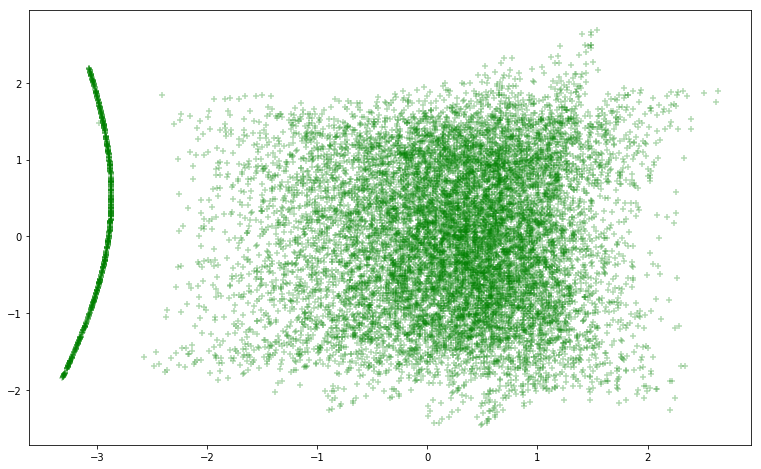

In [50]:
data_pca = KernelPCA(n_components=2, kernel='poly').fit_transform(df_scaled)

set_figuresize(height=8)
plt.scatter(data_pca[:,0], data_pca[:,1], c='g', marker='+', alpha=0.3)
plt.show()

The projected data split into two subgroups. One group consists of a cluster of points disributed across the
2D plane. The other group forms a curve that is clearly seperated from the rest of the points. It is tempted
to assume that one of the groups represented the WS3 pricing anomaly. To verify the claim, we'll
use the clustering algorithm to partition the PCA-projected data. If the claim is correct, then the clustering
algorithm would cluster the WS3 data into one partition.

#### 5.2.1 k-means clustering<a id="Part_5_2_1"></a>
<a href="#Top">Back to page top</a>

We begin by employing the k-means clustering method, which needs to know the number of clusters $k$ to begin 
with. The method then tries to partition the data into $k$ clusters by minimizing the so-called within-cluster
sum of squares (WCSS). The number $k$ is a hyperparameter that needs fine-tuning. In order to determine the 
optimal $k$, we will use the elbow method:
1. Compute k-means clustering for different values of $k$. 
2. For each k, calculate the total WCSS (given by then `inertia_` attribute).
3. Plot the curve of wss vs. $k$, the location of a bend in the plot is considered as an indicator of the 
   ideal number of clusters.

The following cell does exactly the steps just described for 14 different $k$ values:

In [51]:
sum_of_squared_distances = []
krange = range(1, 15)
for k in krange:
    km = KMeans(n_clusters=k, random_state=42, init='k-means++')
    km = km.fit(data_pca)
    sum_of_squared_distances.append(km.inertia_)

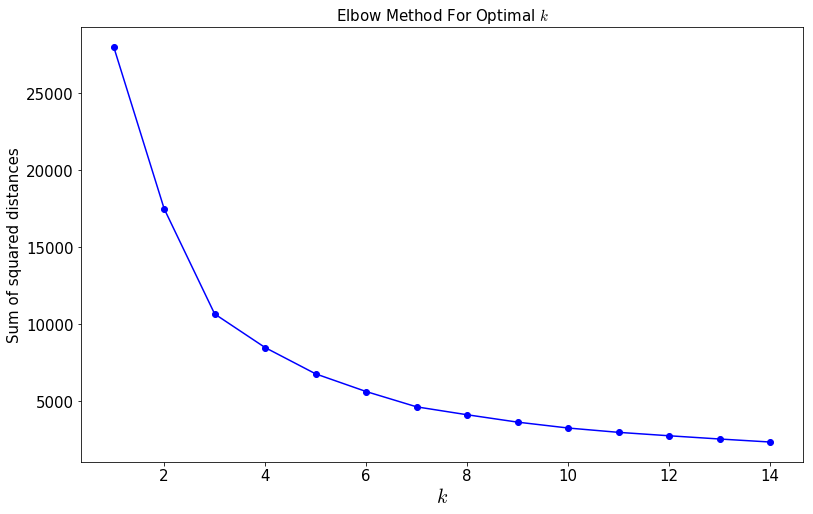

In [52]:
set_figuresize(height=8)
plt.plot(krange, sum_of_squared_distances, 'bo-')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel('Sum of squared distances', fontsize=15)
plt.title('Elbow Method For Optimal $k$', fontsize=15)
plt.show()

It appears that $k$=6 is the "elbow" value. Let's plug in this value into the k-means method (with a different
initial state this time) and apply the method on the PCA-projected data.

In [53]:
n_clusters = 6
labels = KMeans(n_clusters=n_clusters, random_state=77, init='k-means++').fit_predict(data_pca)

Display the first 20 labels.

In [54]:
labels[0:20]

array([4, 4, 2, 0, 4, 4, 1, 4, 3, 0, 3, 3, 4, 3, 1, 1, 2, 3, 4, 1],
      dtype=int32)

In [55]:
df_copy['Label'] = labels
df_copy[(df_copy['Banner']==5) & (df_copy['Region']==0)].head(10)

,Product ID,Banner,Region,Adjusted_Price,Label
7637,557031026.0,5.0,0.0,1.99,5
7638,866698043.0,5.0,0.0,1.99,5
7639,514730047.0,5.0,0.0,1.99,5
7640,789986401.0,5.0,0.0,1.99,5
7641,926444424.0,5.0,0.0,1.99,5
7642,481217425.0,5.0,0.0,1.99,5
7643,400625108.0,5.0,0.0,1.99,5
7644,220433295.0,5.0,0.0,1.99,5
7645,641206219.0,5.0,0.0,1.99,5
7646,48258595.0,5.0,0.0,1.99,5


The above script combines the k-means results into the dataframe `df_copy` then prints out some of the WS3 
data collected in Kentucky, i.e. those $1.99 ones. We can see that these data are tagged with label 5. 

To visualize the classification results, the PCA-projected data will be plotted again on a 2D plane.
However, this time, the data points will be colored using the `tab20c` Matplotlib colormap. For example,
a data point with k-means label 0 will be decorated in color blue #0 from `tab20c`, while a point with 
k-means label 5 will have color orange #5 from the colormap, and so on. The following code shows the
colormap and the corresponding label:

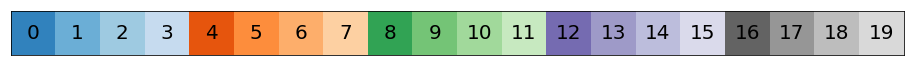

In [56]:
show_colors(cm.colors)

Now it's time to visualize the PCA-projected data combined with k-means labels:

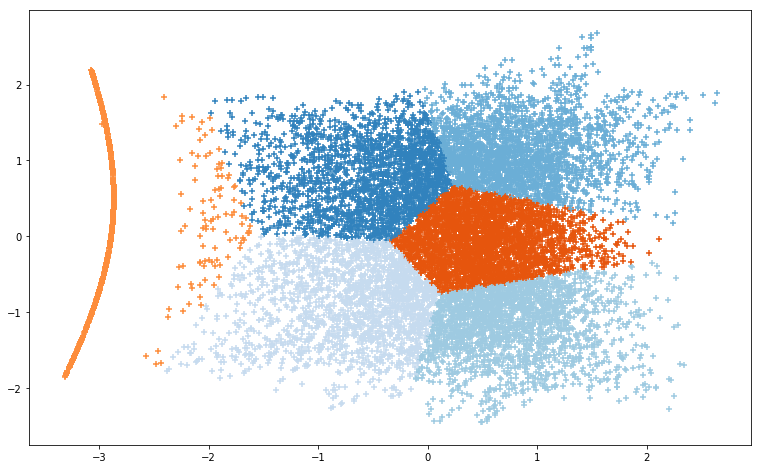

In [57]:
set_figuresize(height=8)
for i in range(0, data_pca.shape[0]):
    for k in range(n_clusters):
        if labels[i] == k:
            plt.scatter(data_pca[i,0], data_pca[i,1], c=cm.colors[k], marker='+')
plt.show()

Again, your milage might vary, but the results diplayed in the above figure clearly put the curve in color
orange #5. On other words, the WS3 $1.99 data are lumped together in a single group by the k-means
method. However, as can be seen from the figure, quite a few data points away from the "curve" are also
included in the anomaly group. This is the trade-off one has to make using k-means. Another trade-off is that
k-means partitions the data that do not belong to the "curve" into several groups. This "artifact" comes from
the fact that k-means is forced to split the data into 6 groups.

#### 5.2.2 DBSCAN clustering<a id="Part_5_2_2"></a>
<a href="#Top">Back to page top</a>

As a comparsion, we will omplement another clustering method in this part of the notebook: DBSCAN, whcih stands
for Density-Based Spatial Clustering of Applications with Noise. The method groups together points that are 
closely packed together. It does not need to know the number of clusters a priori, making DBSCAN a more flexible
clustering method than k-means. Nevertheless, DBSCAN has two hyperparameters: `eps` and `min_samples` that 
strongly impacts the results. Roughly speaking, `eps` determines the maximum distance between two points for
them to be considered in the same group. `min_samples` is the minimum number of samples to form a cluster.

Guided by the results from k-means clustering, we adopt the following settings:
- `eps` = 0.5
- `min_samples` = 15

Let's instantiate a DBSCAN classifier and apply it on the PCA-projected data:

In [58]:
epsilon = 0.5
minimumSamples = 15
db_labels = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit_predict(data_pca)

In [59]:
np.unique(db_labels)

array([0, 1])

The above code snipprt checks unique labels returned by the DBSCAN algorithm. It says there is only two classes.
As a result, we will use the following colormap to represent the labels:

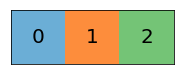

In [60]:
color = [cm.colors[1], cm.colors[5], cm.colors[9]]
show_colors(color)

Which label represents the WS3 anomaly data? Let's find out:

In [61]:
df_copy['Label'] = db_labels
df_copy[(df_copy['Banner']==5) & (df_copy['Region']==0) ].head(10)

,Product ID,Banner,Region,Adjusted_Price,Label
7637,557031026.0,5.0,0.0,1.99,1
7638,866698043.0,5.0,0.0,1.99,1
7639,514730047.0,5.0,0.0,1.99,1
7640,789986401.0,5.0,0.0,1.99,1
7641,926444424.0,5.0,0.0,1.99,1
7642,481217425.0,5.0,0.0,1.99,1
7643,400625108.0,5.0,0.0,1.99,1
7644,220433295.0,5.0,0.0,1.99,1
7645,641206219.0,5.0,0.0,1.99,1
7646,48258595.0,5.0,0.0,1.99,1


So the Kentucky WS3 data are labeled with 1, which is represented by orange #1. Let's visualize the data.

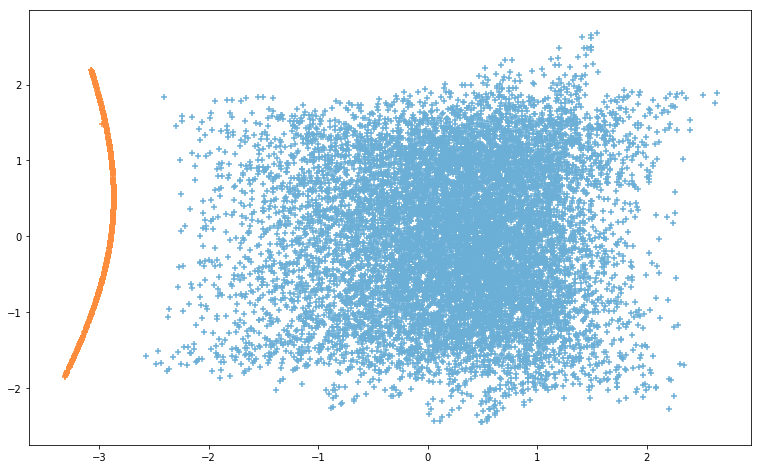

In [62]:
set_figuresize(height=8)
for i in range(0, data_pca.shape[0]):
    for k in range(n_clusters):
        if db_labels[i] == k:
            plt.scatter(data_pca[i,0], data_pca[i,1], c=color[k], marker='+')
plt.show()

The final figure illustrates DBSCAN results, which show the data points are partitioned into just two groups. 
Based on our color coding, the group in orange represents the WS3 anomaly.

Once we have figured out the anomaly, we can use some of the techniques developed in the section
<a href="#Part_5_1">Heuristic approach</a></li> to find out details about the anomaly.